In [50]:
#Import necessary libraries
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Activation, ZeroPadding2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras import backend as K

In [51]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize input images and preprocess them
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# LeNet-5 model
input_shape = (28, 28, 1)
input_layer = Input(shape=input_shape)
conv1 = Conv2D(6, (5, 5), activation='relu', padding='same')(input_layer)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(16, (5, 5), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(pool2)
dense1 = Dense(120, activation='relu')(flatten)
dense2 = Dense(84, activation='relu')(dense1)
output_layer = Dense(10, activation='softmax')(dense2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
469/469 [==============================] - 64s 135ms/step - loss: 0.2810 - accuracy: 0.9183 - val_loss: 0.0688 - val_accuracy: 0.9777
Epoch 2/10
469/469 [==============================] - 56s 120ms/step - loss: 0.0675 - accuracy: 0.9795 - val_loss: 0.0571 - val_accuracy: 0.9813
Epoch 3/10
469/469 [==============================] - 49s 104ms/step - loss: 0.0499 - accuracy: 0.9847 - val_loss: 0.0377 - val_accuracy: 0.9886
Epoch 4/10
469/469 [==============================] - 45s 95ms/step - loss: 0.0382 - accuracy: 0.9882 - val_loss: 0.0346 - val_accuracy: 0.9884
Epoch 5/10
469/469 [==============================] - 36s 77ms/step - loss: 0.0325 - accuracy: 0.9893 - val_loss: 0.0347 - val_accuracy: 0.9889
Epoch 6/10
469/469 [==============================] - 38s 81ms/step - loss: 0.0259 - accuracy: 0.9918 - val_loss: 0.0272 - val_accuracy: 0.9904
Epoch 7/10
469/469 [==============================] - 37s 79ms/step - loss: 0.0219 - accuracy: 0.9934 - val_loss: 0.0379 - val_accura

In [52]:
# defining a model without the fully connected layers
index = [1, 4]
outputs = [model.layers[i].output for i in index]
model2 = Model(inputs=model.inputs, outputs=outputs)

In [53]:
#Pick a random image from test set 

i = x_test[100]
# Preprocess data
i = img_to_array(i)
i = np.expand_dims(i, axis=0)

# Generate features
feature_output = model2.predict(i)

1/1 [==============================] - 0s 76ms/step


In [54]:
# Deconvolution layer 1 

ip_shape = (14, 14, 6)
fltr_ip = Input(shape=ip_shape)
unpool1 = UpSampling2D((2, 2))(fltr_ip)
relu1 = Activation('relu')(unpool1)
deconv1 = Conv2D(1, (5, 5), padding='same')(relu1)

deconvolution1 =Model(inputs=fltr_ip, outputs=deconv1)

In [55]:
# set weights of the deconvolution layer

weights1 = model2.layers[1].get_weights()
weights1_transposed = np.transpose(weights1[0], (0, 1, 3, 2))
deconvolution1.layers[3].set_weights([weights1_transposed, np.zeros(1,)])

In [56]:
# Deconvolution Layer 2

ip_shape = (5, 5, 16)
fltr_ip = Input(shape=ip_shape)
unpool2 = UpSampling2D((2, 2))(fltr_ip)
relu2 = Activation('relu')
relu2 = relu2(unpool2)
deconv2 = Conv2D(6, (5, 5), strides=1, padding='same')(relu2)
padd = ZeroPadding2D(padding=(2,2))(deconv2)

unpool1 = UpSampling2D((2, 2))(padd)
relu1 = Activation('relu')(unpool1)
deconv1 = Conv2D(1, (5, 5), padding='same')(relu1)

deconvolution2 = Model(inputs=fltr_ip, outputs=deconv1)

In [57]:
# set weights of the deconvolution layer 2

weights2 = model2.layers[3].get_weights()
weights2_transposed = np.transpose(weights2[0], (0, 1, 3, 2))
deconvolution2.layers[3].set_weights([weights2_transposed, np.zeros(6,)])

weights1 = model2.layers[1].get_weights()
weights1_transposed = np.transpose(weights1[0], (0, 1, 3, 2))
deconvolution2.layers[7].set_weights([weights1_transposed, np.zeros(1,)])

In [58]:
# get indices of classes 0,1,5,8

idx0 = np.where(np.argmax(y_test, axis=1) == 0)[0]
idx1 = np.where(np.argmax(y_test, axis=1) == 1)[0]
idx5 = np.where(np.argmax(y_test, axis=1) == 5)[0]
idx8 = np.where(np.argmax(y_test, axis=1) == 8)[0]

In [59]:
# function to get feature maps

def get_feature_maps(model, layer_name, input_img):
    # Create intermediate model that outputs the feature maps 
    layer_output = model.get_layer(layer_name).output
    intermediate_model = Model(inputs=model.input, outputs=layer_output)
    # Compute the feature maps for the input image
    feature_maps = intermediate_model.predict(input_img[np.newaxis, ...])

    return feature_maps

1/1 [==============================] - 0s 107ms/step
0


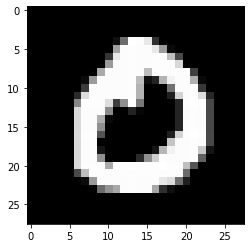

In [60]:
#instance of image of class zero
img = x_test[idx0[100]]
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

plt.imshow(np.squeeze(img),cmap='gray')
pred = model.predict(img)
print(np.argmax(pred))

1/1 [==============================] - 0s 23ms/step


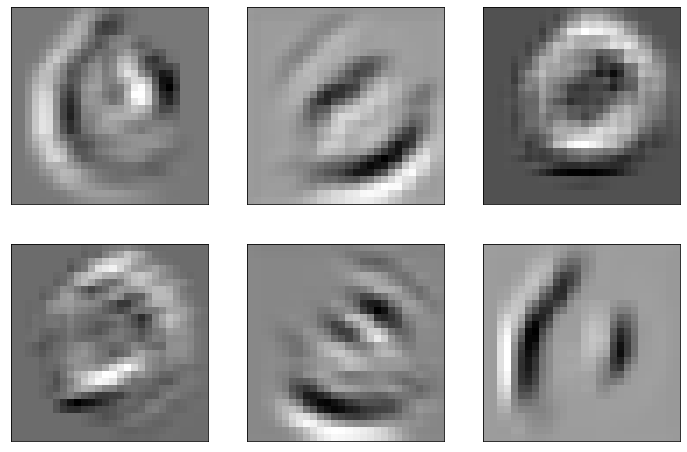

In [61]:
#Plotting activations for class 0
# plotting all activations of 1st convolution

layer = model2.layers
feature_maps = get_feature_maps(model2, layer[2].name,x_test[idx0[100]] )

set_figure=plt.figure(figsize=(3*4, 2*4))
columns = 3
rows = 2
for i in range(1,7):
    arr= np.zeros_like(feature_maps)
    arr[:,:,:,i-1] = feature_maps[:,:,:,i-1]

    output = deconvolution1.predict(arr)
    output = np.squeeze(output)
    set_figure =plt.subplot(rows, columns, i)
    set_figure.set_xticks([])
    set_figure.set_yticks([])
    plt.imshow(output, cmap='gray')
plt.show()


def get_selected_feature_maps(feature_maps, selected_filter):
    selected_feature_maps = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[-1]):
        if i == selected_filter:
            selected_feature_maps[..., i] = feature_maps[..., i]
    return selected_feature_maps

1/1 [==============================] - 0s 37ms/step


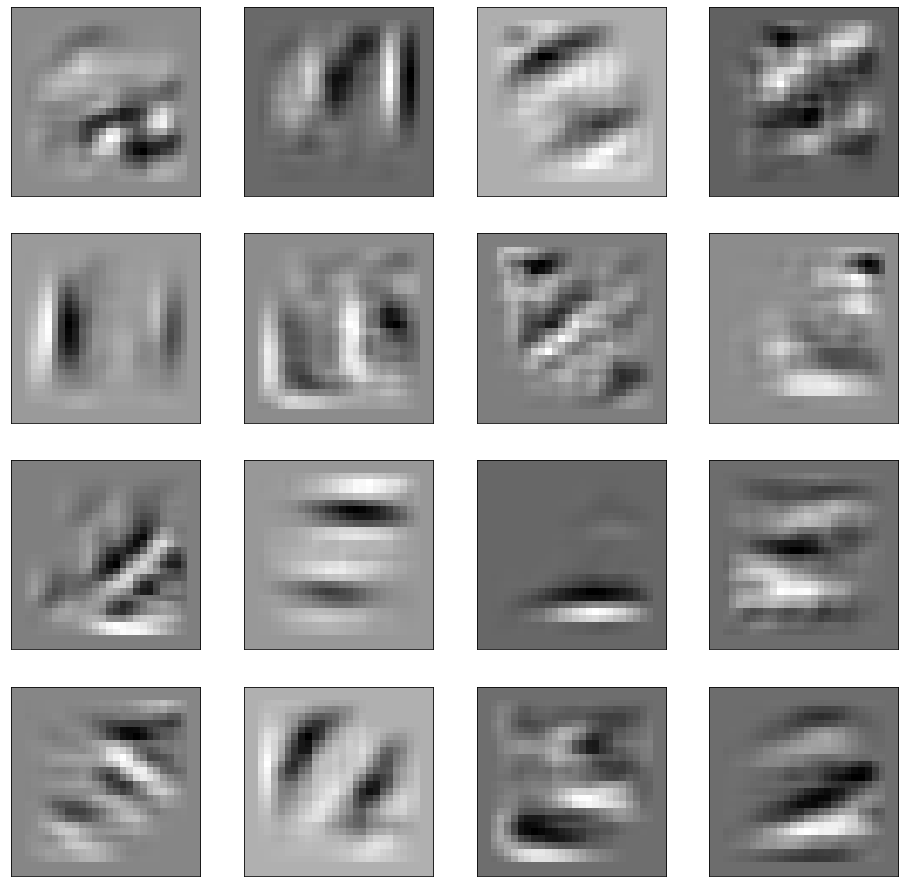

In [62]:
# plotting all activations of 2nd convolution

layer = model2.layers
feature_maps = get_feature_maps(model2, layer[4].name, x_test[idx0[100]])

set_figure=plt.figure(figsize=(4*4, 4*4))
columns = 4
rows = 4
for i in range(1,17):
    arr= np.zeros_like(feature_maps)
    arr[:,:,:,i-1] = feature_maps[:,:,:,i-1]
    output = deconvolution2.predict(arr)
    set_figure =plt.subplot(rows, columns, i)
    set_figure.set_xticks([])
    set_figure.set_yticks([])
    plt.imshow(np.squeeze(output), cmap='gray')
plt.show()

1/1 [==============================] - 0s 57ms/step
1


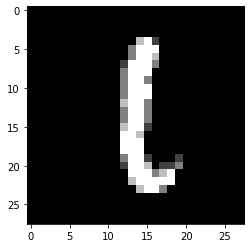

In [63]:
# Class 1
img = x_test[idx1[100]]
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

plt.imshow(np.squeeze(img),cmap='gray')
pred = model.predict(img)
print(np.argmax(pred))

1/1 [==============================] - 0s 24ms/step


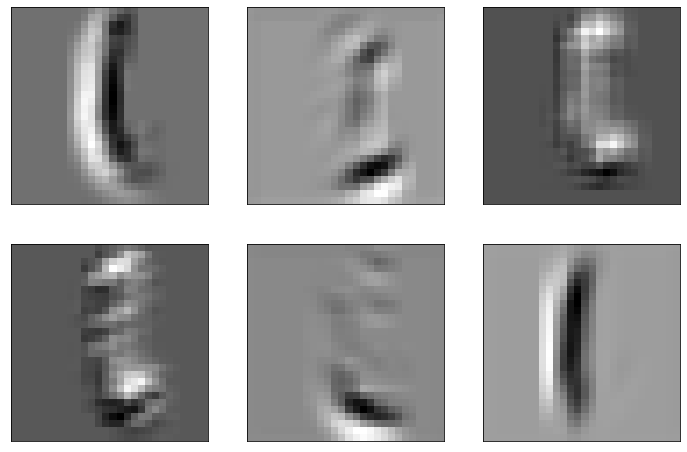

In [64]:

layer = model2.layers
feature_maps = get_feature_maps(model2, layer[2].name,x_test[idx1[100]] )

set_figure=plt.figure(figsize=(3*4, 2*4))
columns = 3
rows = 2
for i in range(1,7):
    arr= np.zeros_like(feature_maps)
    arr[:,:,:,i-1] = feature_maps[:,:,:,i-1]

    output = deconvolution1.predict(arr)
    output = np.squeeze(output)
    set_figure =plt.subplot(rows, columns, i)
    set_figure.set_xticks([])
    set_figure.set_yticks([])
    plt.imshow(output, cmap='gray')
plt.show()


def get_selected_feature_maps(feature_maps, selected_filter):
    selected_feature_maps = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[-1]):
        if i == selected_filter:
            selected_feature_maps[..., i] = feature_maps[..., i]
    return selected_feature_maps

1/1 [==============================] - 0s 27ms/step


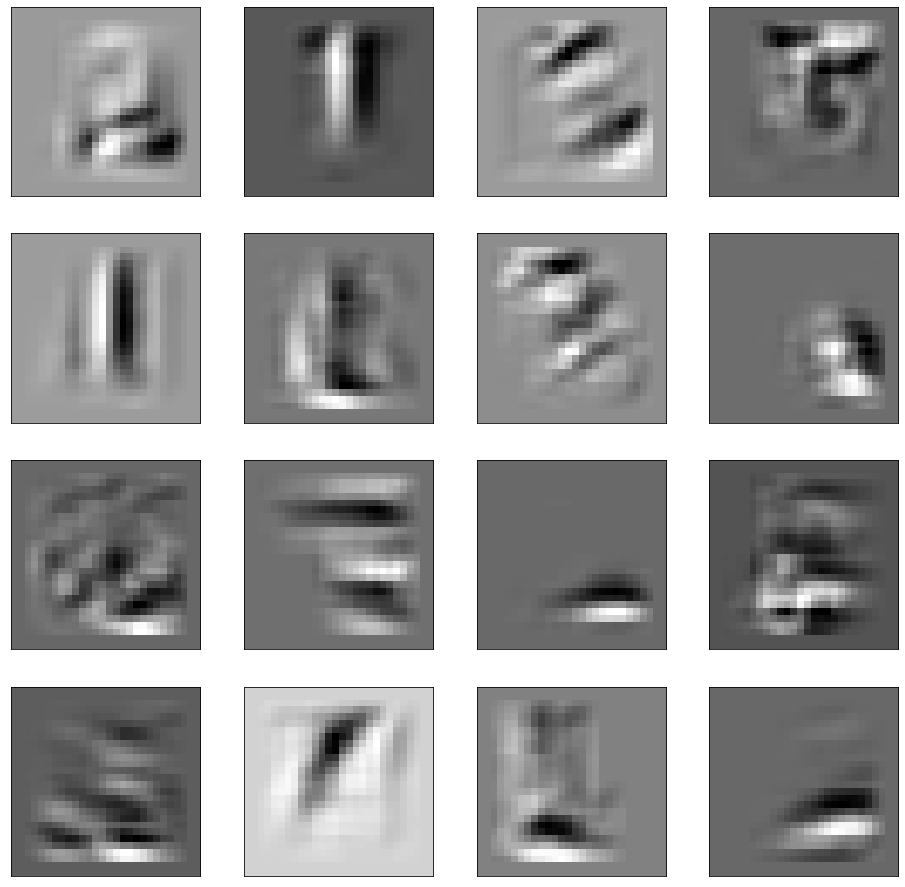

In [65]:

layer = model2.layers
feature_maps = get_feature_maps(model2, layer[4].name, x_test[idx1[100]])

set_figure=plt.figure(figsize=(4*4, 4*4))
columns = 4
rows = 4
for i in range(1,17):
    arr= np.zeros_like(feature_maps)
    arr[:,:,:,i-1] = feature_maps[:,:,:,i-1]
    output = deconvolution2.predict(arr)
    set_figure =plt.subplot(rows, columns, i)
    set_figure.set_xticks([])
    set_figure.set_yticks([])
    plt.imshow(np.squeeze(output), cmap='gray')
plt.show()

1/1 [==============================] - 0s 27ms/step
5


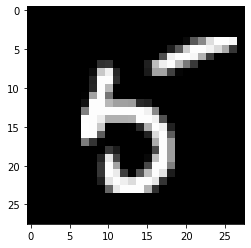

In [66]:
# Class 5
img = x_test[idx5[100]]
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
plt.imshow(np.squeeze(img),cmap='gray')
pred = model.predict(img)
print(np.argmax(pred))

1/1 [==============================] - 0s 29ms/step


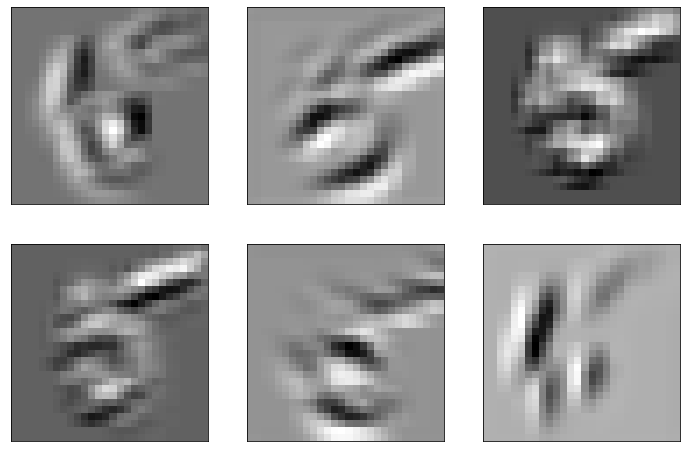

In [67]:


layer = model2.layers
feature_maps = get_feature_maps(model2, layer[2].name,x_test[idx5[100]] )

set_figure=plt.figure(figsize=(3*4, 2*4))
columns = 3
rows = 2
for i in range(1,7):
    arr= np.zeros_like(feature_maps)
    arr[:,:,:,i-1] = feature_maps[:,:,:,i-1]

    output = deconvolution1.predict(arr)
    output = np.squeeze(output)
    set_figure =plt.subplot(rows, columns, i)
    set_figure.set_xticks([])
    set_figure.set_yticks([])
    plt.imshow(output, cmap='gray')
plt.show()


def get_selected_feature_maps(feature_maps, selected_filter):
    selected_feature_maps = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[-1]):
        if i == selected_filter:
            selected_feature_maps[..., i] = feature_maps[..., i]
    return selected_feature_maps

1/1 [==============================] - 0s 23ms/step


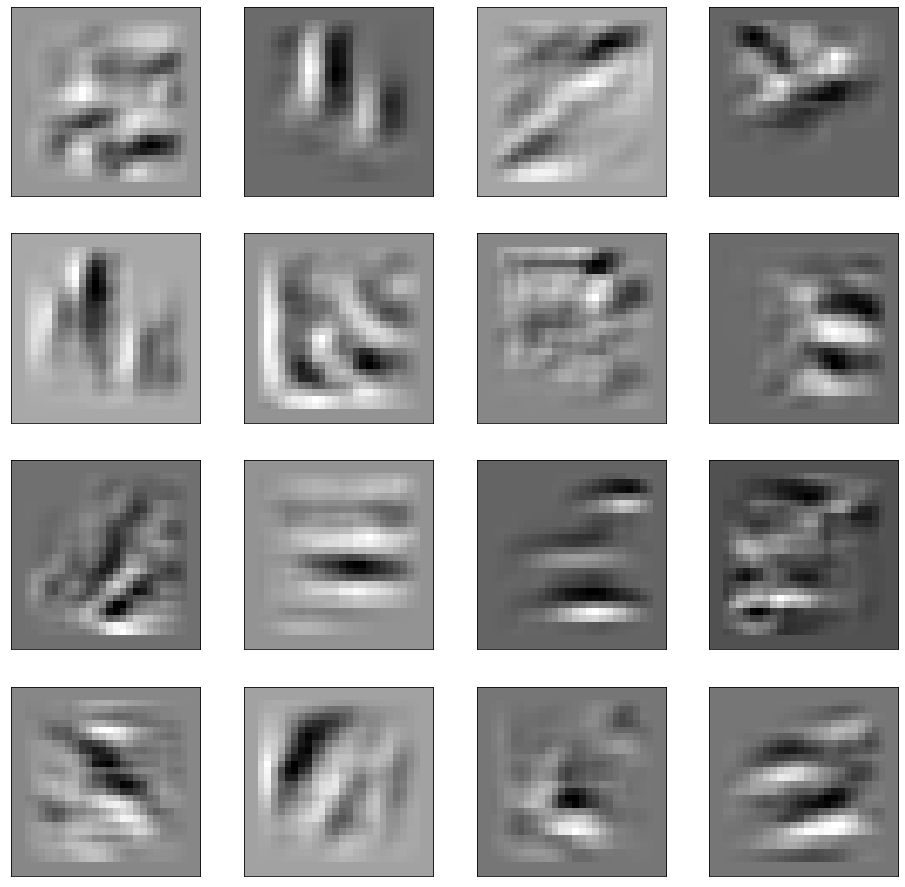

In [68]:


layer = model2.layers
feature_maps = get_feature_maps(model2, layer[4].name, x_test[idx5[100]])

set_figure=plt.figure(figsize=(4*4, 4*4))
columns = 4
rows = 4
for i in range(1,17):
    arr= np.zeros_like(feature_maps)
    arr[:,:,:,i-1] = feature_maps[:,:,:,i-1]
    output = deconvolution2.predict(arr)
    set_figure =plt.subplot(rows, columns, i)
    set_figure.set_xticks([])
    set_figure.set_yticks([])
    plt.imshow(np.squeeze(output), cmap='gray')
plt.show()

1/1 [==============================] - 0s 23ms/step
8


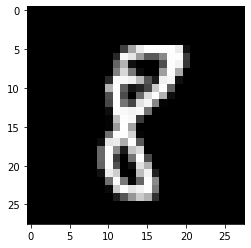

In [69]:
# Class 8
img = x_test[idx8[100]]
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
plt.imshow(np.squeeze(img),cmap='gray')
pred = model.predict(img)
print(np.argmax(pred))

1/1 [==============================] - 0s 23ms/step


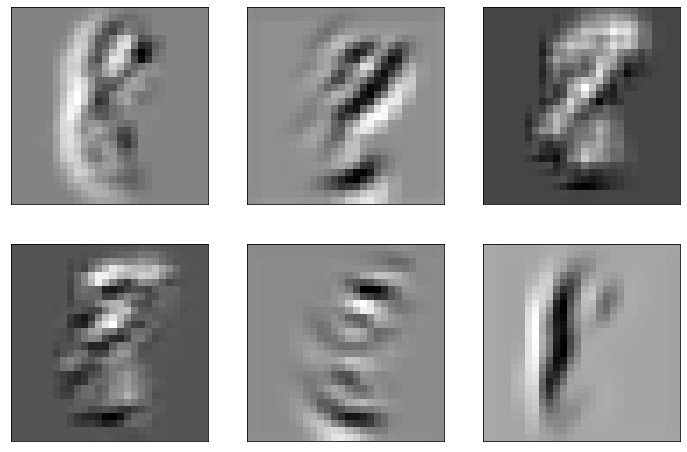

In [70]:

layer = model2.layers
feature_maps = get_feature_maps(model2, layer[2].name,x_test[idx8[100]] )

set_figure=plt.figure(figsize=(3*4, 2*4))
columns = 3
rows = 2
for i in range(1,7):
    arr= np.zeros_like(feature_maps)
    arr[:,:,:,i-1] = feature_maps[:,:,:,i-1]

    output = deconvolution1.predict(arr)
    output = np.squeeze(output)
    set_figure =plt.subplot(rows, columns, i)
    set_figure.set_xticks([])
    set_figure.set_yticks([])
    plt.imshow(output, cmap='gray')
plt.show()


def get_selected_feature_maps(feature_maps, selected_filter):
    selected_feature_maps = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[-1]):
        if i == selected_filter:
            selected_feature_maps[..., i] = feature_maps[..., i]
    return selected_feature_maps

1/1 [==============================] - 0s 24ms/step


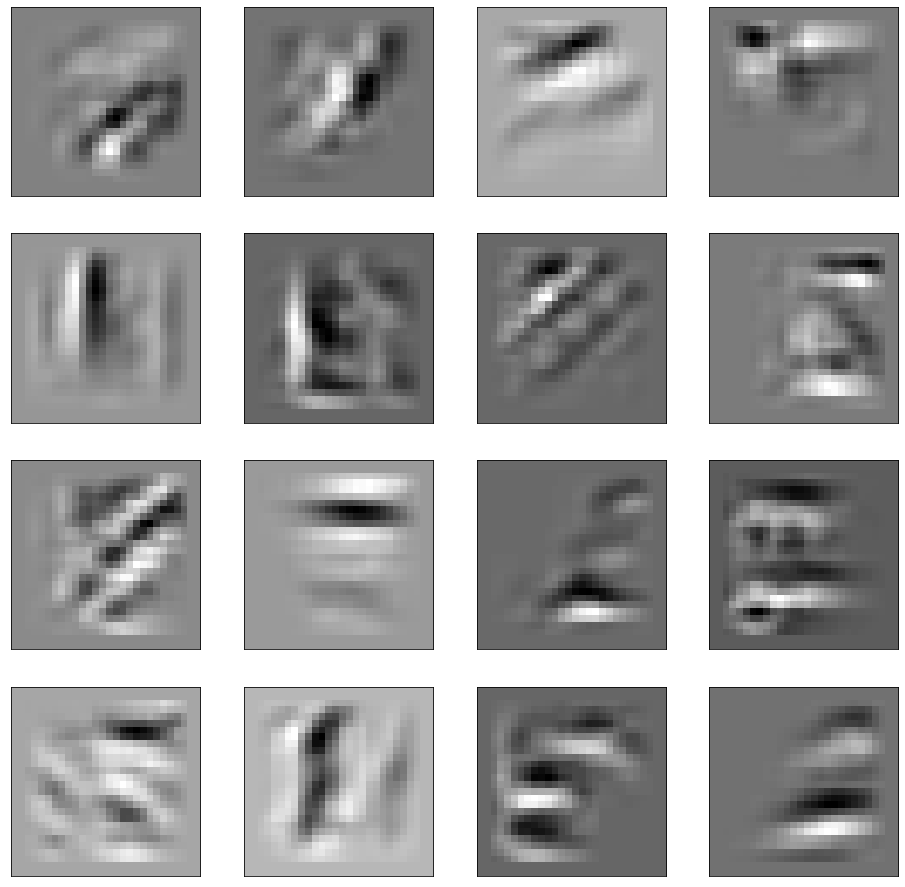

In [71]:


layer = model2.layers
feature_maps = get_feature_maps(model2, layer[4].name, x_test[idx8[100]])

set_figure=plt.figure(figsize=(4*4, 4*4))
columns = 4
rows = 4
for i in range(1,17):
    arr= np.zeros_like(feature_maps)
    arr[:,:,:,i-1] = feature_maps[:,:,:,i-1]
    output = deconvolution2.predict(arr)
    set_figure =plt.subplot(rows, columns, i)
    set_figure.set_xticks([])
    set_figure.set_yticks([])
    plt.imshow(np.squeeze(output), cmap='gray')
plt.show()